# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/Applied Ai/Datasets/Amazon food reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [16]:
final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.
As everybody k

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I finally ordered a couple products from this seller for myself(not as gifts) and I am really happy. This Jade Bonsai is really cool and it arrived fast and in perfect condition. It's in my living room and I get tons of compliments. It's already grown some too and the pot it came in is really nice, looks expensive! Much bigger than I thought it would be even.  Thanks again!!
This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.
As everybody k

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the best hot chocolate.  I first tried this in California and hoped that one day I could find it at a local market.  I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the best hot chocolate I first tried this in California and hoped that one day I could find it at a local market I was excited to find it at Amazon and now I get it shipped to me for gifts and for my husband and myself 


In [24]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:51<00:00, 2118.88it/s]


In [26]:
preprocessed_reviews[1500]

'best hot chocolate first tried california hoped one day could find local market excited find amazon get shipped gifts husband'

In [27]:
final=final.iloc[:100000,:]
with open('final.pkl','wb') as f :
    pickle.dump(final,f)
y=np.array(final["Score"])[:100000]
X=preprocessed_reviews[:100000]
with open('y.pkl','wb') as f :
    pickle.dump(y,f)
with open('preprocessed_reviews.pkl','wb') as f :
    pickle.dump(X,f)


In [66]:
#dataforkmeans
#taking 50k points
X_k=preprocessed_reviews[:50000]
#for agg clustering and dbscan we take 5k points
X_agg=preprocessed_reviews[:5000]
X_db=preprocessed_reviews[:5000]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [6]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [98]:
def BOW(X):
    count_vect = CountVectorizer() #in scikit-learn
    BOW=count_vect.fit_transform(X)
    return  BOW


    
   
   
    

In [99]:
X_k_BOW=BOW(X_k)




In [100]:
with open('X_k_BOW.pkl','wb') as f :
    pickle.dump(X_k_BOW,f)

## [4.2] Bi-Grams and n-Grams.

## [4.3] TF-IDF

In [43]:
def tf_idf(X):
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    X_tfidf=tf_idf_vect.fit_transform(X)
    
    return X_tfidf


In [58]:
X_k_tfidf=tf_idf(X_k)




In [62]:
with open('X_k_tfidf.pkl','wb') as f :
    pickle.dump(X_k_tfidf,f)

Converting text into vectors using Avg W2V

#### [4.4.1.1] Avg W2v

In [199]:
# average Word2Vec
# compute average word2vec for each review.
def AvgWord2Vec(X):
    print(len(X))
    sent_of_train=[]
    for sent in X:
        sent_of_train.append(sent.split())

    # # Train your own Word2Vec model using your own train text corpus 
    # # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    print("number of words that occured minimum 5 times ",len(w2v_words))


    train_vectors = []
    for sent in sent_of_train:
        sent_vec = np.zeros(50) 
        cnt_words =0; 
        for word in sent: # 
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        train_vectors.append(sent_vec)

    # compute average word2vec for each review for X_test .
   
    return  train_vectors


In [200]:
X_k_avgw2v=AvgWord2Vec(X_k)
X_agg_avgw2v=AvgWord2Vec(X_agg)
X_db_avgw2v=AvgWord2Vec(X_db)




50000
number of words that occured minimum 5 times  13694
5000
number of words that occured minimum 5 times  5052
5000
number of words that occured minimum 5 times  5052


In [202]:
with open('X_k_avgw2v.pkl','wb') as f :
    pickle.dump(X_k_avgw2v,f)
with open('X_agg_avgw2v.pkl','wb') as f :
    pickle.dump(X_agg_avgw2v,f)
with open('X_db_avgw2v.pkl','wb') as f :
    pickle.dump(X_db_avgw2v,f)

#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]


In [248]:
def tfidfW2v(X):
    word2vec_corpus=[]
    for sentence in X:
        word2vec_corpus.append(sentence.split())

    #min_count = 5 considers only those words which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=50, min_count=5, workers=8)
    word2vec_words = list(word2vec_model.wv.vocab)

    #Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
    tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X)

    #This method returns the Average Word2Vec vectors for all reviews in a given dataset
    def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

        #word2vec_corpus will store the list of words for each review.
        word2vec_corpus=[]
        for sentence in dataset:
            word2vec_corpus.append(sentence.split())

        #Use the earlier TF-IDF object to vectorize test and cv data.
        tf_idf_matrix = tf_idf_object.transform(dataset)
        tfidf_features = tf_idf_object.get_feature_names() 

        # We are building a dictionary with words as a key, and the idfs as value
        dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

        #Algorithm for finding the TF-IDF weighted average word2vec vectors.
        tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
        row=0;
        for sentence in tqdm(word2vec_corpus): #For each review/sentence 
            sent_vec = np.zeros(50) #50 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
            weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
            for word in sentence: #For each word in a review/sentence
                if((word in word2vec_words) and (word in tfidf_features)):
                    word_vectors = word2vec_model.wv[word]
                    tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                    sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            tfidf_sent_vectors.append(sent_vec)
            row += 1

        tfidf_sent_vectors = np.array(tfidf_sent_vectors)
        return tfidf_sent_vectors

    #Converting the words to word vector representation.
    X_tfidfw2vec = vectorize_tfidf_w2v(X, tf_idf_object, word2vec_model, word2vec_words)
    
    return X_tfidfw2vec


In [ ]:
X_k_tfidfw2v=tfidfW2v(X_k)
X_agg_tfidfw2v=tfidfW2v(X_agg)
X_db_tfidfw2v=tfidfW2v(X_db)

In [251]:
with open('X_k_tfidfw2v.pkl','wb') as f :
    pickle.dump(X_k_tfidfw2v,f)
with open('X_agg_tfidfw2v.pkl','wb') as f :
    pickle.dump(X_agg_tfidfw2v,f)
with open('X_db_tfidfw2v','wb') as f :
    pickle.dump(X_db_tfidfw2v,f)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

In [132]:
#checking number of clusters
def cluster(X):
    scaler=StandardScaler(with_mean=False)
    X=scaler.fit_transform(X)
    inertia=[]
    num_cluster=np.arange(1,10)
    for k in num_cluster:
        kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        inertia.append(kmeans.inertia_)
    plot_metric(num_cluster,inertia)
    

In [133]:
#plotting for the optimal number of clusters
def plot_metric(optimal_cluster,inertia):
    plt.plot(optimal_cluster,inertia)
    plt.xlabel('Clusters')
    plt.ylabel('Inertia')
    plt.title('Finding Optimal Clusters')
    plt.show()

In [143]:
#fitting the data with the optimalnumber of clusters
def fit_data(reviews,X,opt_cluster):
    k_means=KMeans(n_clusters=opt_cluster, random_state=0).fit(X)
    printwcloud(reviews,k_means.labels_,opt_cluster)

In [144]:
def printwcloud(reviews,labels,opt_cluster):
    results = pd.DataFrame()
    results['text'] = reviews
    results['cluster'] = labels
    fig = plt.figure(figsize=(12,10))
    for k in range(opt_cluster):

        feat_cloud = " ".join(word for word in results[results['cluster']==k]['text'])
        wordcloud_pos = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(feat_cloud)

        # Display the generated image:
        temp=k+1
        ax = fig.add_subplot(3,3,temp)

        #plt.subplot(temp)
        ax.imshow(wordcloud_pos, interpolation='bilinear')
        ax.axis("off")
        title='Wordcloud for cluster:'+str(k+1)
        ax.set_title(title)
    plt.tight_layout()  
    plt.show()
    

In [136]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [148]:
with open('X_k_BOW.pkl','rb') as f :
    X_k_BOW=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)

In [149]:
reviews=reviews[:50000]


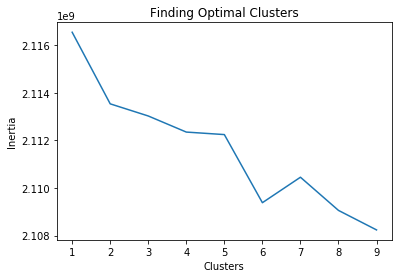

In [139]:
cluster(X_k_BOW)

In [151]:
opt_cluster=6

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

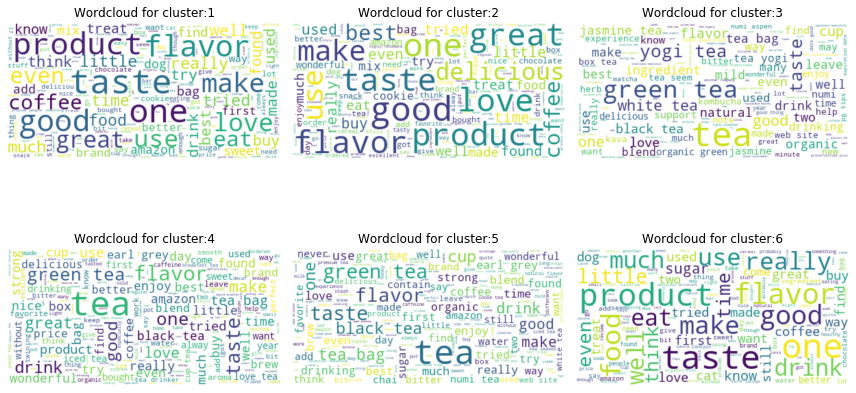

In [152]:
# Please write all the code with proper documentation
#fitting the data with the optimal cluster and printing wordcloud
from wordcloud import WordCloud
fit_data(reviews,X_k_BOW,opt_cluster)

Cluster 1: Mainly about Flavor, taste
Cluster 2: Mainly about Product,love,delicious etc
CLuster 3: Mainly about tea
Cluster 4: Mainly about tea,drink etc
Cluster 5: Mainly about flavor,tea
Cluster 6: Mainly about food,taste

Note:Clustering of kmeans on BOW is not satisfactory

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [153]:
# Please write all the code with proper documentation
with open('X_k_tfidf.pkl','rb') as f :
    X_k_tfidf=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:50000]



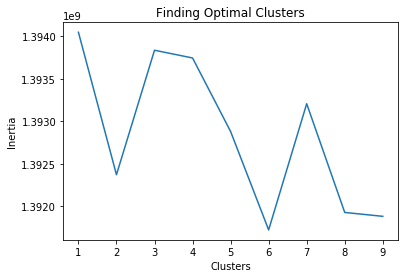

In [154]:
cluster(X_k_tfidf)

In [155]:
opt_cluster=6

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

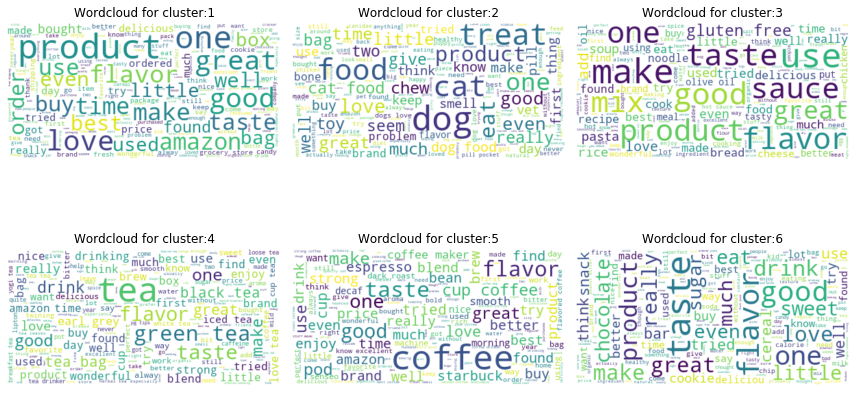

In [156]:
# Please write all the code with proper documentation
#fitting the data with the optimal cluster and printing wordcloud
from wordcloud import WordCloud
fit_data(reviews,X_k_tfidf,opt_cluster)

Cluster 1: Mainly about Flavor,product
Cluster 2: Mainly about cat,dog,food
CLuster 3: Mainly about sauce,product
Cluster 4: Mainly about tea,drink etc 
Cluster 5: Mainly about coffee
Cluster 6: Mainly about choclate,great etc
    
Note:Result is better than BOW but still not satisfactory

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [158]:
# Please write all the code with proper documentation
with open('X_k_avgw2v.pkl','rb') as f :
    X_k_avgw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:50000]


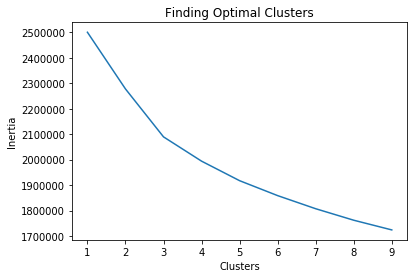

In [159]:
cluster(X_k_avgw2v)

In [166]:
opt_cluster=3

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

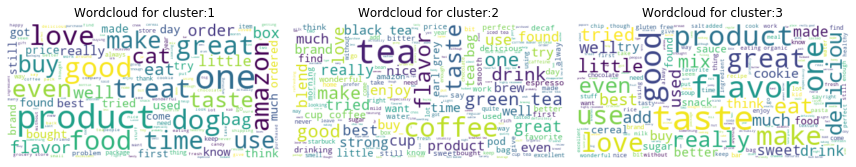

In [167]:
# Please write all the code with proper documentation
fit_data(reviews,X_k_avgw2v,opt_cluster)

Cluster 1: good,love,product etc
Cluster 2:tea,flavor,taste etc
Cluster 3:make,delicious,good etc
    
Note:Much better result than tfidf and BOW

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [168]:
# Please write all the code with proper documentation
with open('X_k_tfidfw2v.pkl','rb') as f :
    X_k_tfidfw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:50000]

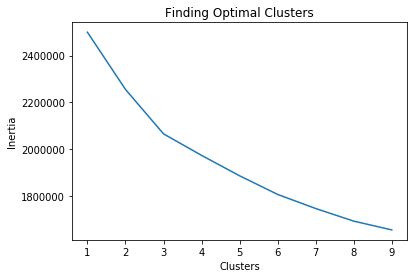

In [169]:
cluster(X_k_tfidfw2v)

In [176]:
opt_cluster=3

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

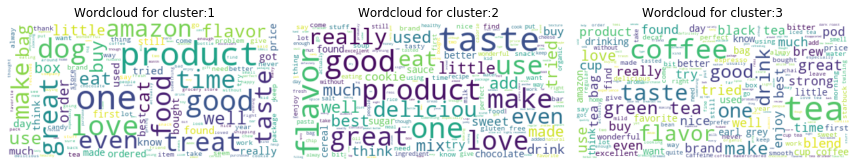

In [177]:
# Please write all the code with proper documentation
fit_data(reviews,X_k_tfidfw2v,opt_cluster)

Cluster1:product,food,dog etc
Cluster2:great,love,delicious etc
Cluster3:coffee,tea etc
    
Note:Results not satisfactory compared to avgw2v


## [5.2] Agglomerative Clustering

In [179]:
from sklearn.cluster import AgglomerativeClustering as AC

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [203]:
# Please write all the code with proper documentation
with open('X_agg_avgw2v.pkl','rb') as f :
    X_agg_avgw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:5000]


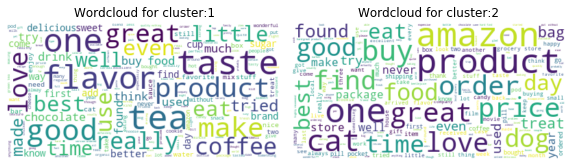

In [205]:
cluster =2
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_avgw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

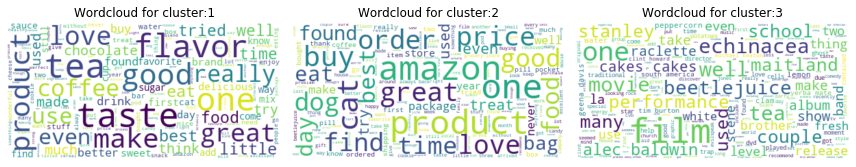

In [206]:
cluster =3
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_avgw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

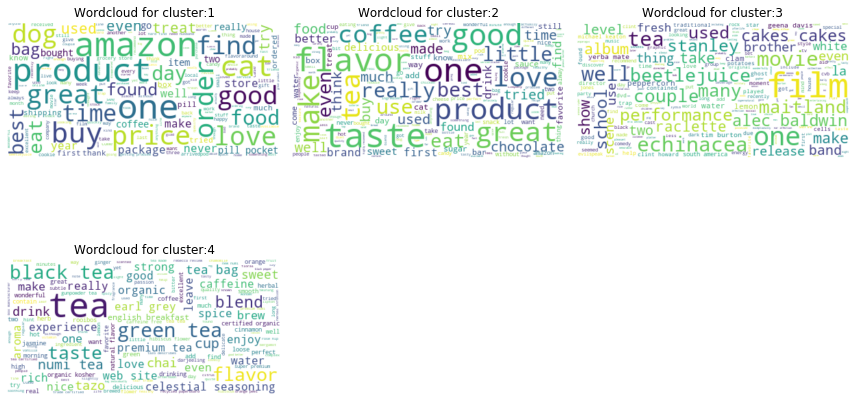

In [207]:
cluster =4
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_avgw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

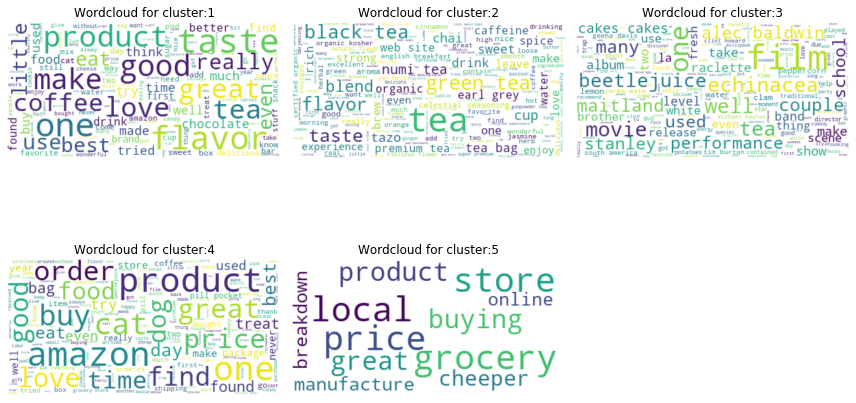

In [208]:
cluster =5
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_avgw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

So cluster =3 is giving us the best possible results

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

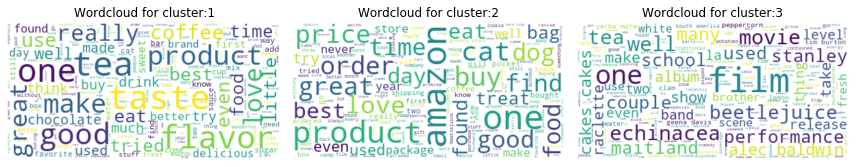

In [211]:
# Please write all the code with proper documentation
cluster =3
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_avgw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

Cluster 1:good,taste,tea,product etc
Cluster 2:love,amazon,cat,dog etc
Cluster 3:movie,film,performanceetc


### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [212]:
# Please write all the code with proper documentation
with open('X_agg_tfidfw2v.pkl','rb') as f :
    X_agg_tfidfw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:5000]



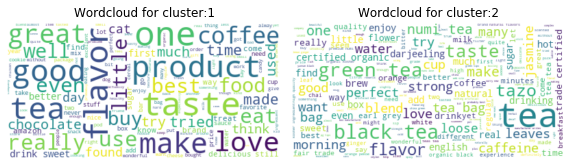

In [213]:
cluster =2
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_tfidfw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

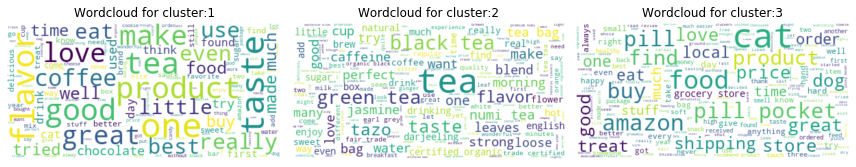

In [214]:
cluster =3
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_tfidfw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

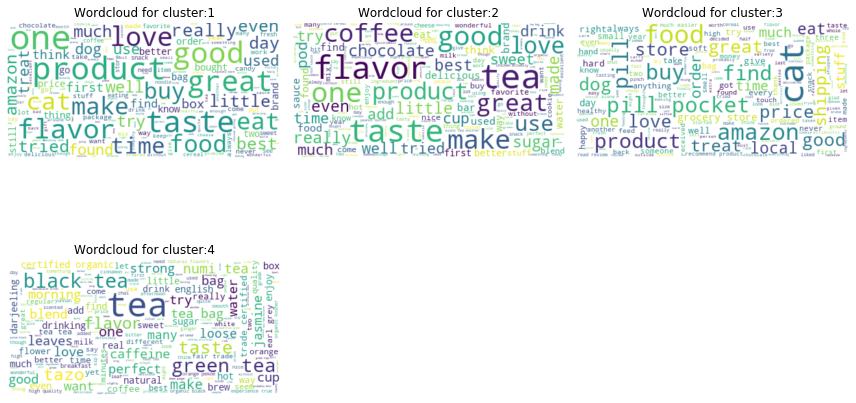

In [215]:
cluster =4
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_tfidfw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

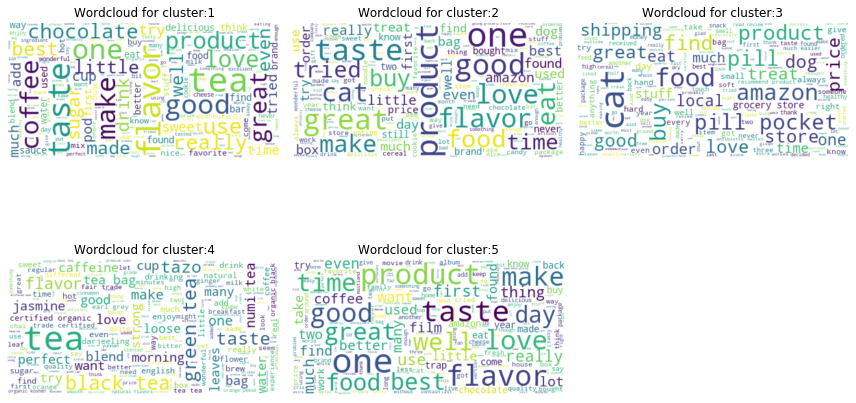

In [216]:
cluster =5
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_tfidfw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)

So we can see cluster=5 is  giving a good clustering result

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

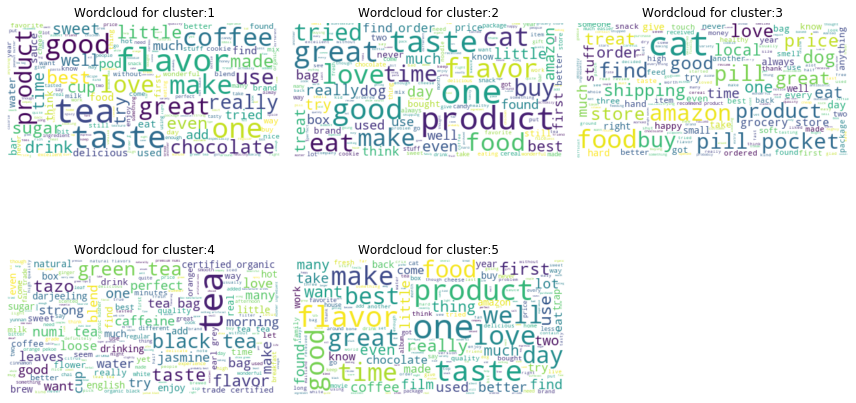

In [217]:
# Please write all the code with proper documentation
#taking cluster=5
cluster =5
AC_clusters = AC(n_clusters=cluster,affinity='euclidean',linkage='complete').fit(X_agg_tfidfw2v)
printwcloud(reviews,AC_clusters.labels_,cluster)


Cluster 1:flavor,tea good etc
Cluster 2:great,good,flavor etc
Cluster 3:cat,dog,food
Cluster 4:tea,taste,tazo etc
Cluster 5:taste,time,goodetc

## [5.3] DBSCAN Clustering

In [218]:
from sklearn.cluster import DBSCAN

Finding best eps for DBSCAN¶
To find best eps, we use KNN distance plot. In this plot, we compute the distance of K nearest neighbors from each point and plot it. The plot should resemble a knee(or elbow) and the point (distance) where we see a structural change in the plot should be used as eps

In [220]:
from sklearn.neighbors import NearestNeighbors

we are taking minpt=3

In [228]:
def plot_neighbourgraph(X):
    X=scaler.fit_transform(X)
    ns = 3
    nbrs = NearestNeighbors(n_neighbors=ns).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distanceDec = sorted(distances[:,ns-1],reverse=True)
    plt.plot(list(range(1,len(X)+1)), distanceDec)
    plt.show()

In [237]:
def getdbscan(ns,eps,X):
    X=scaler.fit_transform(X)
    clustering_db=DBSCAN(eps=eps,min_samples=ns).fit(X)
    return clustering_db.labels_
    
    

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [226]:
with open('X_db_avgw2v.pkl','rb') as f :
    X_db_avgw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:5000]

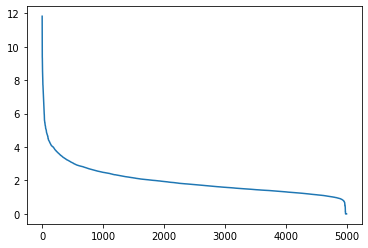

In [229]:
# Please write all the code with proper documentation
plot_neighbourgraph(X_db_avgw2v)

So from the graph we can take eps=3

In [238]:
# Please write all the code with proper documentation
ns=3
eps=3
clustering_db_labels=getdbscan(ns,eps,X_db_avgw2v)
len(np.unique(clustering_db_labels))

11

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [241]:
np.unique(clustering_db_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [243]:
results = pd.DataFrame()
results['text'] = reviews
results['cluster'] = clustering_db_labels
results.head()

text  cluster
0  witty little book makes son laugh loud recite ...        0
1  remember seeing show aired television years ag...        0
2  beetlejuice well written movie everything exce...        0
3  twist rumplestiskin captured film starring mic...        0
4  beetlejuice excellent funny movie keaton hilar...        0

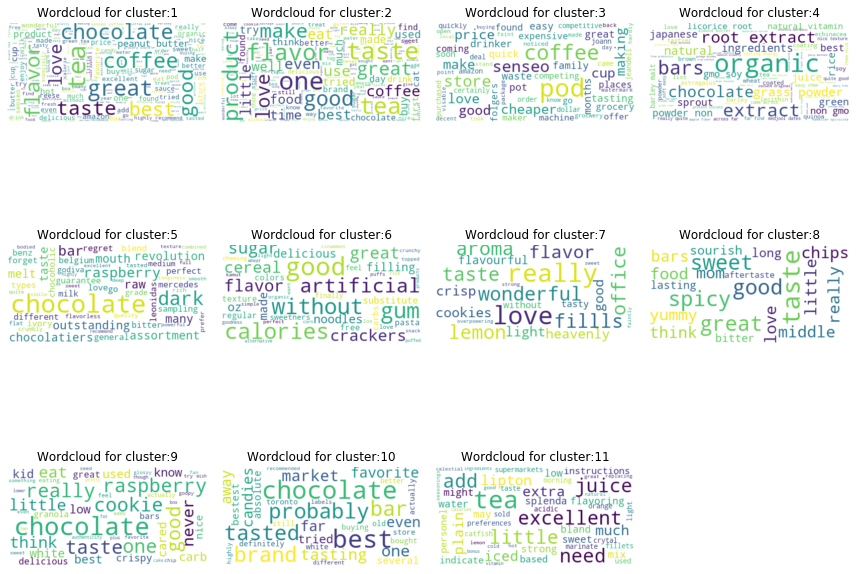

In [245]:

fig = plt.figure(figsize=(12,10))
for k in range(-1,10,1):
    
    feat_cloud = " ".join(word for word in results[results['cluster']==k]['text'])
    wordcloud_pos = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(feat_cloud)

    # Display the generated image:
    temp=k+2
    ax = fig.add_subplot(3,4,temp)
    
    #plt.subplot(temp)
    ax.imshow(wordcloud_pos, interpolation='bilinear')
    ax.axis("off")
    title='Wordcloud for cluster:'+str(k+2)
    ax.set_title(title)
plt.tight_layout()  
plt.show()


cluster 1:Choclate,great,tea,cofee etc
cluster 2:good,taste etc
cluster 3:senseo,price,coffe etc
cluster 4:Organic,extract,choaclate etc
cluster 5:Chocholate,dark
cluster 6:calories,artificial,crackers
cluster 7:really,love,filfills
cluster 8:sweet ,tasty spicy etc
cluster 9: choclate,cookie,crispy etc
cluster 10: best,brand,tasting etc
cluster 11:excellent,little,add,might


### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [252]:
# Please write all the code with proper documentation
with open('X_db_tfidfw2v','rb') as f :
    X_db_tfidfw2v=pickle.load(f)
with open('preprocessed_reviews.pkl','rb') as f :
    reviews=pickle.load(f)
reviews=reviews[:5000]

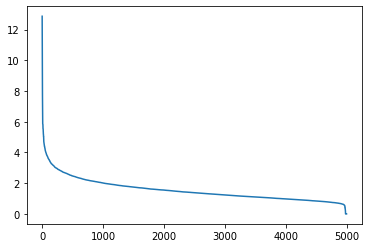

In [253]:
plot_neighbourgraph(X_db_tfidfw2v)

In [255]:
eps=3 #from the graph
ns=3

In [256]:
clustering_db_labels=getdbscan(ns,eps,X_db_tfidfw2v)
np.unique(clustering_db_labels)

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

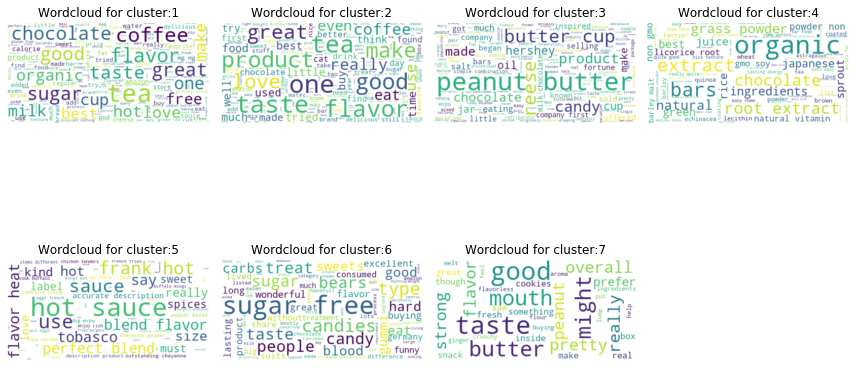

In [257]:
results = pd.DataFrame()
results['text'] = reviews
results['cluster'] = clustering_db_labels
results.head()
fig = plt.figure(figsize=(12,10))
for k in range(-1,6,1):
    
    feat_cloud = " ".join(word for word in results[results['cluster']==k]['text'])
    wordcloud_pos = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(feat_cloud)

    # Display the generated image:
    temp=k+2
    ax = fig.add_subplot(3,4,temp)
    
    #plt.subplot(temp)
    ax.imshow(wordcloud_pos, interpolation='bilinear')
    ax.axis("off")
    title='Wordcloud for cluster:'+str(k+2)
    ax.set_title(title)
plt.tight_layout()  
plt.show()


Cluster 1:choclate,coffee,great etc
Cluster 2:great,really,good etc
Cluster 3:butter,candy,peanut
Cluster 4:organic,extract etc
Cluster 5:hot,sauce etc
Cluster 6:Sugar,free,candy,people
Cluster 7:taste.butter,really,overall

# [6] Conclusions

Few points to Note:
1) K means clustering on BOW and TFIDF is not giving us satisfsctory results
2)K means on Avgw2v and tfidfw2v is giving us better results but not satisfsctory
3)Agg clustering is giving us good results but it cannot be used in production for its time and space complexity
4)DB scan on tfidfw2v has given us the best clustering result with number of clusters =7